In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get TEOTIL2 data from GitHub

Reads TEOTIL2 results CSVs from GitHub for specified vassdragsområder and creates simplified Excel files. Useful for sharing TEOTIL2 data for particular regions.

In [2]:
# Period of interest
st_yr = 2015
end_yr = 2019

# Vassdragsområder of interest
vassoms = [f"{i:03d}." for i in range(1, 26)]

# Output Excel file
out_xlsx = None  # r"teotil2_vassom001-017_1990-2021.xlsx"

In [3]:
df_list = []
for year in range(st_yr, end_yr + 1):
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_output_data/teotil2_results_{year}.csv"
    df = pd.read_csv(url)
    index_cols = ["regine", "regine_ned", "year", "vassom"]
    other_cols = [col for col in df.columns if col not in index_cols]
    df["year"] = year
    df["vassom"] = df["regine"].str[:4]
    df = df[index_cols + other_cols]
    df = df.query("vassom in @vassoms").round(2)
    df_list.append(df)

df = pd.concat(df_list)
df.sort_values(["regine", "year"], inplace=True)
vassom_df = df.query("regine in @vassoms")
del df["vassom"], vassom_df["vassom"]

if out_xlsx:
    # Write output
    with pd.ExcelWriter(out_xlsx) as writer:
        df.to_excel(writer, sheet_name="all_regines", index=False)
        vassom_df.to_excel(writer, sheet_name="vassom_only", index=False)

# Stacked bar charts showing proportions by source

In [4]:
def proportions_by_source(vassom_df, pars, srcs):
    """For each vassdragsområde in 'vassom_df', estimate the percentage contribution from each
    source in 'srcs'.

    Args
        vassom_df: Dataframe. TEOTIL2 results for vassdragsområder of interest
        pars: List of str. Parameters to consider. One or more of ['tot-n', 'tot-p']
        srcs: List of str. Sources to consider. One or more of
            ["agri", "aqu", "ind", "nat-diff", "ren", "spr", "urban"]

    Returns
        Dataframe.
    """
    # Select columns of interest
    cols = ["regine", "year"] + [
        col for col in vassom_df.columns if col.startswith("accum")
    ]
    vassom_df = vassom_df[cols].copy()
    vassom_df.columns = [
        col.replace("nat_diff", "nat-diff") for col in vassom_df.columns
    ]

    # Combine point and diffuse from agri
    for par in pars:
        agri_cols = [f"accum_agri_diff_{par}_tonnes", f"accum_agri_pt_{par}_tonnes"]
        vassom_df[f"accum_agri_{par}_tonnes"] = vassom_df[agri_cols].sum(axis=1)
        vassom_df.drop(columns=agri_cols, inplace=True)

    # Calculate percentages for cols of interest
    for par in pars:
        for src in srcs:
            vassom_df[f"{src}_{par}_pct"] = (
                100
                * vassom_df[f"accum_{src}_{par}_tonnes"]
                / vassom_df[f"accum_all_sources_{par}_tonnes"]
            )

    # Select percentage columns
    cols = ["regine", "year"] + [
        col for col in vassom_df.columns if col.endswith("pct")
    ]
    vassom_df = vassom_df[cols]

    # Group by 'regine' and calculate mean
    vassom_df = vassom_df.groupby(["regine"]).mean(numeric_only=True).reset_index()
    del vassom_df["year"]

    # Melt dataframe and split 'variable' into 'source' and 'parameter'
    vassom_df = vassom_df.melt(id_vars="regine")
    vassom_df[["source", "parameter"]] = vassom_df["variable"].str.split(
        "_", n=2, expand=True
    )[[0, 1]]
    vassom_df.drop(columns="variable", inplace=True)

    # Rename 'value' to 'proportion_pct' and reorder columns
    vassom_df.rename({"value": "proportion_pct"}, axis="columns", inplace=True)
    vassom_df = vassom_df[["regine", "parameter", "source", "proportion_pct"]]

    # Tidy
    vassom_df = vassom_df.sort_values(["regine", "parameter", "source"]).reset_index(drop=True)
    vassom_df["proportion_pct"] = vassom_df["proportion_pct"].round(1)

    return vassom_df


def plot_stacked_bar_charts(prop_df):
    """Create a stacked bar chart showing nutrient source proportion by vassdragsområde.

    Args
        prop_df: dataframe. As returned by 'proportions_by_source'

    Returns
        None. Plot is created.
    """
    # Pivot the DataFrame to get the data in the right format
    df_pivot = prop_df.pivot_table(
        index=["regine", "parameter"],
        columns="source",
        values="proportion_pct",
        fill_value=0,
    )

    # Get the list of parameters
    parameters = prop_df["parameter"].unique()

    # For each parameter, create a subplot
    for i, parameter in enumerate(parameters):
        plt.figure(i)
        df_subset = df_pivot.xs(parameter, level="parameter")
        ax = df_subset.plot(kind="bar", stacked=True, figsize=(8, 4))
        plt.title(parameter.upper())
        plt.ylabel("Proportion (%)")
        plt.xlabel("Vassdragsområde")
        plt.tight_layout()
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [5]:
# User input
pars = ["tot-n", "tot-p"]
srcs = ["agri", "aqu", "ind", "nat-diff", "ren", "spr", "urban"]
prop_csv = f"/home/jovyan/projects/oslofjord_modelling/baseline-terrestrial-inputs/data/vassom_props_by_src_{st_yr}-{end_yr}.csv"

In [6]:
# Get proportions
prop_df = proportions_by_source(vassom_df, pars, srcs)
prop_df.to_csv(prop_csv, index=False)

prop_df.head(10)

,regine,parameter,source,proportion_pct
0,001.,tot-n,agri,38.3
1,001.,tot-n,aqu,0.0
2,001.,tot-n,ind,6.7
3,001.,tot-n,nat-diff,36.0
4,001.,tot-n,ren,15.5
5,001.,tot-n,spr,2.9
6,001.,tot-n,urban,0.6
7,001.,tot-p,agri,29.5
8,001.,tot-p,aqu,0.0
9,001.,tot-p,ind,28.5


Mean nutrient proportions by source and vassdragsområde from 2015 - 2019:


<Figure size 640x480 with 0 Axes>

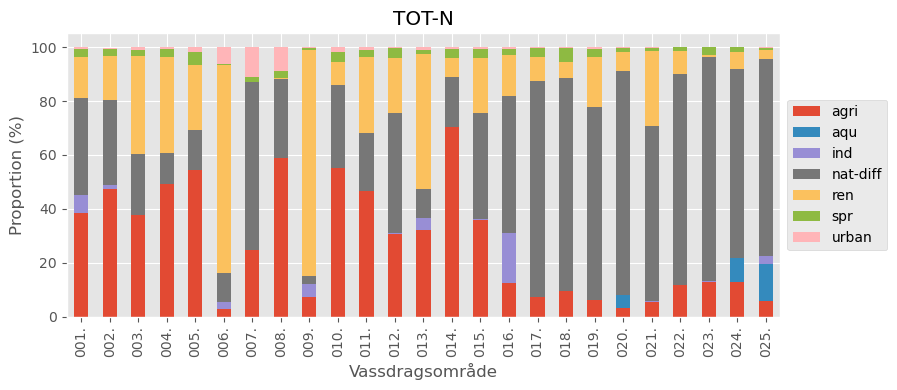

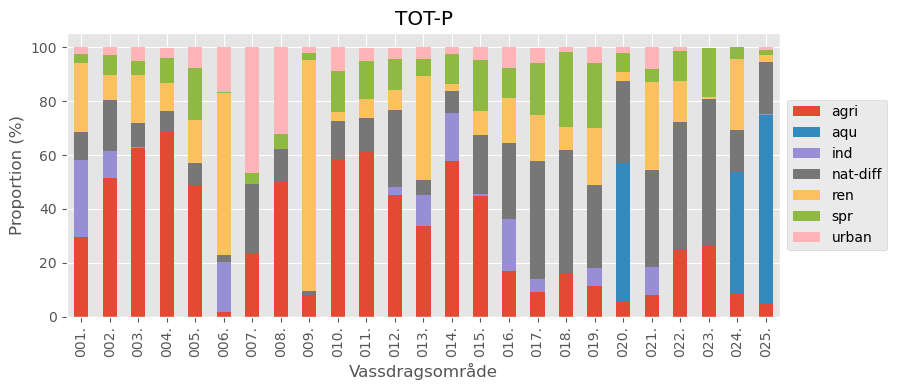

In [7]:
# Plot
print(f"Mean nutrient proportions by source and vassdragsområde from {st_yr} - {end_yr}:")
plot_stacked_bar_charts(prop_df)